In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
# Load the CSV file
df = pd.read_csv('output.csv')

# Encode labels into integers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['tweet_text'], df['label_encoded'], test_size=0.2, random_state=42)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)


In [8]:
# Tokenize and pad sequences
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [9]:
model_rnn = Sequential()
model_rnn.add(Embedding(max_words, 100, input_length=max_len))
model_rnn.add(SpatialDropout1D(0.2))
model_rnn.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model_rnn.add(Dense(9, activation='softmax'))  # Assuming 9 classes

model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_rnn.summary())

# Train the model
history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), verbose=2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
22/22 - 13s - 570ms/step - accuracy: 0.4875 - loss: 1.7330 - val_accuracy: 0.5308 - val_loss: 1.5032
Epoch 2/5
22/22 - 10s - 434ms/step - accuracy: 0.5051 - loss: 1.5134 - val_accuracy: 0.5308 - val_loss: 1.4665
Epoch 3/5
22/22 - 12s - 548ms/step - accuracy: 0.5051 - loss: 1.4261 - val_accuracy: 0.5367 - val_loss: 1.3662
Epoch 4/5
22/22 - 11s - 521ms/step - accuracy: 0.5684 - loss: 1.2267 - val_accuracy: 0.5806 - val_loss: 1.2054
Epoch 5/5
22/22 - 7s - 322ms/step - accuracy: 0.6926 - loss: 0.9470 - val_accuracy: 0.6129 - val_loss: 1.1553


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
RNN Accuracy: 0.6129032258064516
RNN Precision: 0.5178056097961
RNN Recall: 0.6129032258064516
RNN F1-score: 0.5570067296389373


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


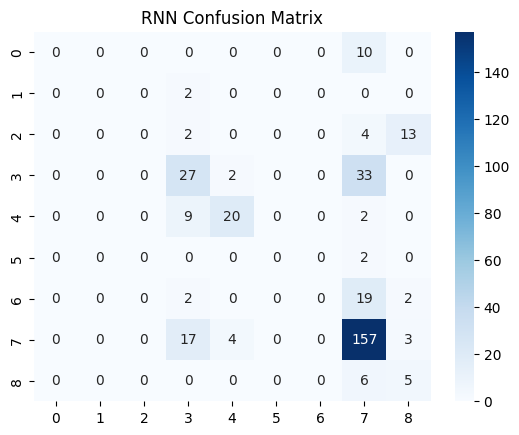

In [10]:
y_pred_rnn = model_rnn.predict(X_test_pad)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)

accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')
recall_rnn = recall_score(y_test, y_pred_rnn, average='weighted')
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')

print(f'RNN Accuracy: {accuracy_rnn}')
print(f'RNN Precision: {precision_rnn}')
print(f'RNN Recall: {recall_rnn}')
print(f'RNN F1-score: {f1_rnn}')

confusion_rnn = confusion_matrix(y_test, y_pred_rnn)
sns.heatmap(confusion_rnn, annot=True, fmt='d', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.show()

In [11]:
# Use BERT Tokenizer
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts):
    return tokenizer_bert(texts, padding=True, truncation=True, return_tensors='tf')

train_encodings = encode_texts(X_train.tolist())
test_encodings = encode_texts(X_test.tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
!pip install transformers tensorflow

import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AdamWeightDecay

# Use DistilBERT Tokenizer
tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def encode_texts(texts):
    return tokenizer_distilbert(texts, padding=True, truncation=True, return_tensors='tf')

train_encodings = encode_texts(X_train.tolist())
test_encodings = encode_texts(X_test.tolist())

# DistilBERT Model
model_distilbert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=9)

# Use AdamWeightDecay optimizer
optimizer = AdamWeightDecay(learning_rate=5e-5)
model_distilbert.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# One-hot encode the labels (as before)
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=9)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=9)

# Train the model (using encoded labels)
history_distilbert = model_distilbert.fit(train_encodings['input_ids'], y_train_encoded, epochs=5, batch_size=64,
                                         validation_data=(test_encodings['input_ids'], y_test_encoded), verbose=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
22/22 - 584s - loss: 4.7219 - accuracy: 0.0551 - val_loss: 1.8556 - val_accuracy: 0.0323 - 584s/epoch - 27s/step
Epoch 2/5
22/22 - 521s - loss: 10.9460 - accuracy: 0.0456 - val_loss: 11.8557 - val_accuracy: 0.0821 - 521s/epoch - 24s/step
Epoch 3/5
22/22 - 512s - loss: 7.8080 - accuracy: 0.0838 - val_loss: 10.9187 - val_accuracy: 0.0821 - 512s/epoch - 23s/step
Epoch 4/5
22/22 - 512s - loss: 5.9200 - accuracy: 0.0853 - val_loss: 4.4904 - val_accuracy: 0.0762 - 512s/epoch - 23s/step
Epoch 5/5
22/22 - 513s - loss: 6.7318 - accuracy: 0.0728 - val_loss: 5.7193 - val_accuracy: 0.0674 - 513s/epoch - 23s/step


11/11 [==============================] - 57s 5s/step
BERT Accuracy: 0.06744868035190615
BERT Precision: 0.034706208248852066
BERT Recall: 0.06744868035190615
BERT F1-score: 0.013591321181454008


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


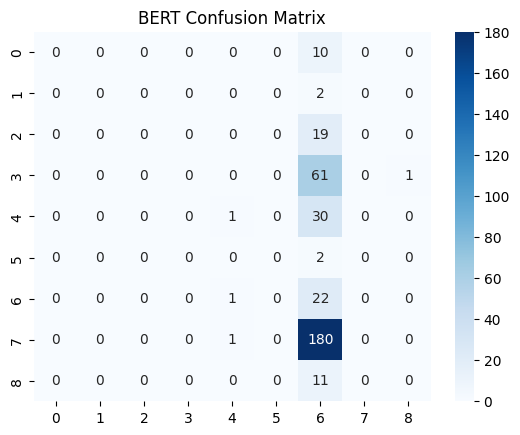

In [15]:
y_pred_bert = model_distilbert.predict(test_encodings['input_ids'])
y_pred_bert = np.argmax(y_pred_bert.logits, axis=1)

accuracy_bert = accuracy_score(y_test, y_pred_bert)
precision_bert = precision_score(y_test, y_pred_bert, average='weighted')
recall_bert = recall_score(y_test, y_pred_bert, average='weighted')
f1_bert = f1_score(y_test, y_pred_bert, average='weighted')

print(f'BERT Accuracy: {accuracy_bert}')
print(f'BERT Precision: {precision_bert}')
print(f'BERT Recall: {recall_bert}')
print(f'BERT F1-score: {f1_bert}')

confusion_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(confusion_bert, annot=True, fmt='d', cmap='Blues')
plt.title('BERT Confusion Matrix')
plt.show()


In [16]:
#models comaparison
print("Model Comparison:")
print(f'RNN - Accuracy: {accuracy_rnn}, Precision: {precision_rnn}, Recall: {recall_rnn}, F1-score: {f1_rnn}')
print(f'BERT - Accuracy: {accuracy_bert}, Precision: {precision_bert}, Recall: {recall_bert}, F1-score: {f1_bert}')

if accuracy_bert > accuracy_rnn:
    print("BERT outperforms RNN.")
else:
    print("RNN outperforms BERT.")


Model Comparison:
RNN - Accuracy: 0.6129032258064516, Precision: 0.5178056097961, Recall: 0.6129032258064516, F1-score: 0.5570067296389373
BERT - Accuracy: 0.06744868035190615, Precision: 0.034706208248852066, Recall: 0.06744868035190615, F1-score: 0.013591321181454008
RNN outperforms BERT.


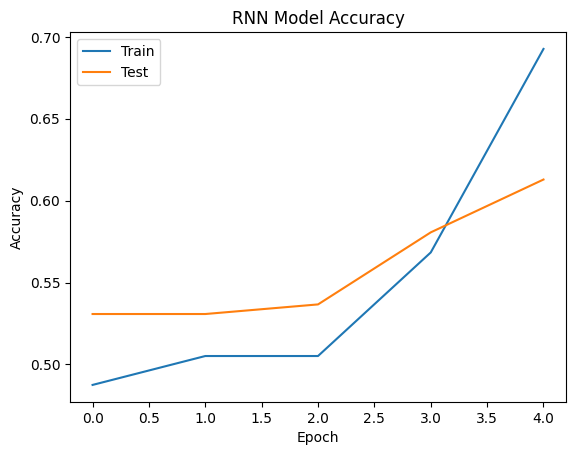

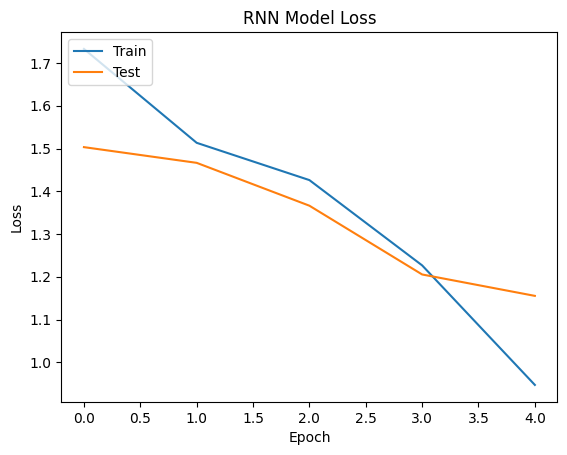

Tweet Text: RT @FabianKeiser: The Ring of Fire gets angry? Yesterday #Earthquake in #Chile (6.6). Today in #California (6.0) and now #Peru (7.0). http:…
Actual Label: ['other_useful_information']
Predicted Label: ['other_useful_information']

Tweet Text: #RT #ipad #iphone VIDEO: California shaken by earthquake http://t.co/3ajpHAarpy #app http://t.co/jRVYofNltS
Actual Label: ['other_useful_information']
Predicted Label: ['other_useful_information']

Tweet Text: RT @ABC7Chicago: UPDATE: Earthquake in California's Napa Valley near San Francisco injures at least 211 http://t.co/OyVj8rTn2O
Actual Label: ['injured_or_dead_people']
Predicted Label: ['injured_or_dead_people']

Tweet Text: #Travel Indy Car race on after Northern California quake – SFGate http://t.co/elv0vISsKF
Actual Label: ['not_related_or_irrelevant']
Predicted Label: ['other_useful_information']

Tweet Text: What Caused California's Napa Earthquake? http://t.co/fMQehvkxGK #space
Actual Label: ['other_useful_information']
Pre

In [17]:
# Check the training history for trends in loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Test the RNN on a few samples
for i in range(5):  # Checking for 5 random test samples
    print("Tweet Text:", X_test.iloc[i])
    print("Actual Label:", label_encoder.inverse_transform([y_test[i]]))
    print("Predicted Label:", label_encoder.inverse_transform([y_pred_rnn[i]]))
    print()


In [20]:
from transformers import BertTokenizer, TFBertForSequenceClassification

# Define the path where you want to save your model and tokenizer
path_to_save_model = r'C:\Users\LENOVO\Downloads\save_models'
path_to_save_tokenizer = r'C:\Users\LENOVO\Downloads\save_models'

# Save the trained model
model_distilbert.save_pretrained(path_to_save_model)

# Save the tokenizer
tokenizer_distilbert.save_pretrained(path_to_save_tokenizer)

print(f'Model saved to {path_to_save_model}')
print(f'Tokenizer saved to {path_to_save_tokenizer}')



Model saved to C:\Users\LENOVO\Downloads\save_models
Tokenizer saved to C:\Users\LENOVO\Downloads\save_models


In [43]:
# Integration=============

# load image model:

from tensorflow.keras.models import load_model
image_model = load_model(r'disaster_classification_model.h5')


In [44]:
import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer

In [67]:
# Preprocessing functions
def preprocess_text(text):
    # Add your text preprocessing code here
    image = Image.open(image_path)
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.permute(1, 2, 0))]) #this line will move the channels to the last dimension
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    tokenizer_distilbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Initialize tokenizer
    tokens = tokenizer_distilbert(text, return_tensors='tf')
    # Extract input_ids and attention_mask tensors
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
     # Return a dictionary of tensors
    return tokens, image,input_ids,attention_mask


def preprocess_image(image_path):
    # Add your image preprocessing code here
    image = Image.open(image_path)
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor()])
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

In [69]:
nlp_model = TFBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Unified prediction function
def predict_social_media_post(text, image_path):
    # Text prediction
    tokens = preprocess_text(text)
    with torch.no_grad():
        text_output = nlp_model(tokens)[0]

    # Image prediction
    image = preprocess_image(image_path)
    image_output = image_model.predict(image)

    # Combine the predictions (e.g., by adding probabilities, or logical conditions)
    combined_output = combine_predictions(text_output, image_output)

    return combined_output

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.transformer.layer.1.attention.q_lin.bias', 'distilbert.transformer.layer.4.output_layer_norm.bias', 'distilbert.transformer.layer.1.attention.k_lin.bias', 'distilbert.transformer.layer.2.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.3.attention.q_lin.weight', 'distilbert.transformer.layer.4.attention.q_lin.bias', 'distilbert.transformer.layer.1.ffn.lin2.bias', 'distilbert.transformer.layer.2.attention.q_lin.bias', 'distilbert.transformer.layer.2.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer

In [70]:
def combine_predictions(text_output, image_output):
    # Define your logic to combine NLP and Image predictions here
    combined_result = (text_output + image_output) / 2  # Example
    return combined_result

In [71]:
# Example usage
text = "There is a flood in the city!"
image_path = r"drought.jpg"
result = predict_social_media_post(text, image_path)
print("Combined prediction:", result)


ValueError: Exception encountered when calling layer 'tf_bert_for_sequence_classification_5' (type TFBertForSequenceClassification).

Data of type <class 'transformers.tokenization_utils_base.BatchEncoding'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_for_sequence_classification_5' (type TFBertForSequenceClassification):
  • input_ids=({'input_ids': 'tf.Tensor(shape=(1, 10), dtype=int32)', 'attention_mask': 'tf.Tensor(shape=(1, 10), dtype=int32)'}, 'tensor([[[[0.0706, 0.1020, 0.1529],\n          [0.0745, 0.1059, 0.1569],\n          [0.0745, 0.1059, 0.1569],\n          ...,\n          [0.1098, 0.1020, 0.1216],\n          [0.1176, 0.1098, 0.1294],\n          [0.1255, 0.1137, 0.1373]],\n\n         [[0.0706, 0.1020, 0.1529],\n          [0.0745, 0.1059, 0.1569],\n          [0.0745, 0.1059, 0.1569],\n          ...,\n          [0.1137, 0.1059, 0.1255],\n          [0.1216, 0.1137, 0.1333],\n          [0.1373, 0.1216, 0.1451]],\n\n         [[0.0706, 0.1020, 0.1529],\n          [0.0745, 0.1059, 0.1569],\n          [0.0745, 0.1059, 0.1569],\n          ...,\n          [0.1176, 0.1098, 0.1294],\n          [0.1255, 0.1176, 0.1373],\n          [0.1451, 0.1255, 0.1412]],\n\n         ...,\n\n         [[0.1333, 0.0863, 0.0471],\n          [0.1451, 0.0941, 0.0549],\n          [0.1569, 0.0941, 0.0510],\n          ...,\n          [0.2196, 0.1373, 0.0745],\n          [0.3765, 0.2549, 0.1647],\n          [0.4078, 0.2784, 0.1725]],\n\n         [[0.1216, 0.0824, 0.0431],\n          [0.1373, 0.0863, 0.0549],\n          [0.1490, 0.0902, 0.0510],\n          ...,\n          [0.3647, 0.2510, 0.1608],\n          [0.4275, 0.2902, 0.1922],\n          [0.4275, 0.2941, 0.1882]],\n\n         [[0.1020, 0.0627, 0.0275],\n          [0.1216, 0.0745, 0.0431],\n          [0.1412, 0.0824, 0.0431],\n          ...,\n          [0.4392, 0.2941, 0.1804],\n          [0.4588, 0.3137, 0.2039],\n          [0.4431, 0.3098, 0.2039]]]])', 'tf.Tensor(shape=(1, 10), dtype=int32)', 'tf.Tensor(shape=(1, 10), dtype=int32)')
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • labels=None
  • training=False